## Airline Data Modeling

# Questions for Brian:
- log transform outliers in Arrival Delay??
- how to pull out most important features? Random forest?
    - feature interpretability
- Where to go with current model scores? --- which models?
- Should I undersample?
- XG Boost?

In [235]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2 as pg
import itertools

from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification
from scipy.spatial.distance import euclidean as euc
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, f1_score, auc,
plot_confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [108]:
# imported CSV

df_model = pd.read_csv("/Users/Tara8082/GIT/ProjectGIT/Project_3/df_clean.csv", index_col = 0)

## Setting Up Model

In [36]:
# Designating 'neutral or dissatisfied' = 1, 'satisfied' = 0

df_model['Satisfaction'] = df_model['Satisfaction'].apply(lambda x: 1 if x == 'neutral or dissatisfied' else 0)

In [72]:
# Designates X (features), y (target)

features = ['Gender', 'Customer Type', 'Age', 'Type Of Travel', 'Class',
       'Flight Distance', 'Inflight Wifi Service', 'Dep Arr Time Convenience',
       'Ease Of Online Booking', 'Gate Location', 'Food And Drink',
       'Online Boarding', 'Seat Comfort', 'Inflight Entertainment',
       'Onboard Service', 'Leg Room Service', 'Baggage Handling',
       'Checkin Service', 'Inflight Service', 'Cleanliness',
       'Departure Delay In Minutes']

X = df_model[features]
y = df_model['Satisfaction']


In [73]:
# Train/test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=6)

### Preprocessing: One Hot Encoding Categorical Features 

In [74]:
# Specify categorical features

categoricals = ['Gender', 'Customer Type', 'Type Of Travel', 'Class']
non_cat = ['Flight Distance', 'Inflight Wifi Service',
       'Dep Arr Time Convenience', 'Ease Of Online Booking',
       'Gate Location', 'Food And Drink', 'Online Boarding', 'Seat Comfort',
       'Inflight Entertainment', 'Onboard Service', 'Leg Room Service',
       'Baggage Handling', 'Checkin Service', 'Inflight Service',
       'Cleanliness', 'Departure Delay In Minutes']

ohe = OneHotEncoder(sparse=False)

cat_matrix_train = ohe.fit_transform(X_train.loc[:, categoricals])

X_train_ohe = pd.DataFrame(cat_matrix_train,
                           columns=ohe.get_feature_names(categoricals),
                           index=X_train.index)

# Combine continuous and categorical TRAINING data
X_train_preprocessed = pd.concat([X_train[non_cat], X_train_ohe], axis=1)

# Scale training data
ss = StandardScaler()
X_train_preprocessed = ss.fit_transform(X_train_preprocessed)

In [75]:
# Create validation set with X_train_preprocessed data

X_train_scaled, X_val_scaled, y_train, y_val = train_test_split(X_train_preprocessed, y_train, test_size=.3, random_state=2)

In [76]:
# Transform and scale TEST set --- DON'T TOUCH TEST UNTIL END.

cat_matrix_test = ohe.transform(X_test.loc[:, categoricals]) #only transform on the test set!

X_test_ohe = pd.DataFrame(cat_matrix_test,
                           columns=ohe.get_feature_names(categoricals),
                           index=X_test.index)

# Combine continuous and categorical TEST data
X_test_preprocessed = pd.concat([X_test[non_cat], X_test_ohe], axis=1)

# Scale test data
X_test_preprocessed = ss.transform(X_test_preprocessed)

### Setting Up Function to Create A Confusion Matrix
- Using Kaggle blog (https://www.kaggle.com/grfiv4/plot-a-confusion-matrix)

In [148]:
def plot_kconfusion_matrix(cm,target_names,title='Confusion matrix',cmap=None,normalize=True):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Oranges')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=0)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label\nAccuracy={:0.4f}; Misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

## K Nearest Neighbors

I will begin with K Nearest Neighbors by testing for the optimal k and associated root MSE in the range of 1-15.

In [65]:
# Testing for optimal k from 1-15

ks = range(1, 15)
test_errors = np.zeros(len(list(ks)))

for i,k in enumerate(ks):
    
    # Using nn for testing k
    nn = KNeighborsClassifier(n_neighbors = k)

    # Fit to training data
    nn.fit(X_train_scaled, y_train)

    # Predict on validation data
    test_k_preds = nn.predict(X_val_scaled)
    
    # Test errors = Mean Squared Errors of predictions/y-val
    test_errors[i] = np.sqrt(mean_squared_error(y_val, test_k_preds))
    print(k, test_errors[i])

1 0.2945393978724883
2 0.3018161170649324
3 0.2728927123983732
4 0.2723531316185696
5 0.2712029579942498
6 0.26593106101859343
7 0.26950260920725877
8 0.26627656078884776
9 0.26984353611043294
10 0.2684772309458182
11 0.2715417500788652
12 0.2690929267674012
13 0.27336397190490946
14 0.27072793680989765


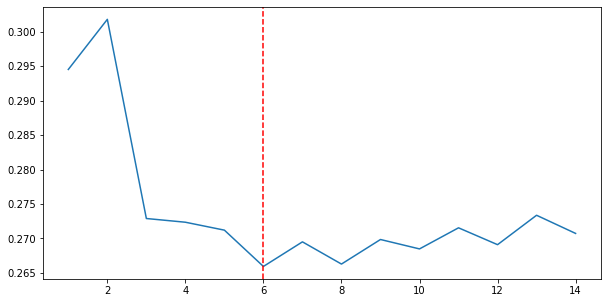

In [69]:
# graph K, test_error scores
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(list(ks), test_errors)
ax.axvline(list(ks)[np.argmin(test_errors)], linestyle='--', color='red');

In [109]:
# Finding optimal K and associated root MSE
optimal_k = list(ks)[np.argmin(test_errors)]

optimal_error = np.min(test_errors)

print(f'Optimal number of Neighbors: {optimal_k}\nRoot Mean Squared Error: {optimal_error:.4f}')

Optimal number of Neighbors: 6
Root Mean Squared Error: 0.2659


## KNN with Optimal k

In [151]:
knn = KNeighborsClassifier(n_neighbors = optimal_k)

# Fit to training data
knn.fit(X_train_scaled, y_train)

# Predict on scaled data
knn_preds = knn.predict(X_val_scaled)

In [152]:
print("Training score: ", knn.score(X_train_scaled, y_train))
print("Validation score: ", knn.score(X_val_scaled, y_val))

Training score:  0.9463970495523893
Validation score:  0.9292806707855251


In [153]:
print(classification_report(y_val, knn_preds))

# classification report shows how well classified what I hadn't seen

              precision    recall  f1-score   support

           0       0.94      0.90      0.92     11782
           1       0.92      0.95      0.94     15410

    accuracy                           0.93     27192
   macro avg       0.93      0.93      0.93     27192
weighted avg       0.93      0.93      0.93     27192



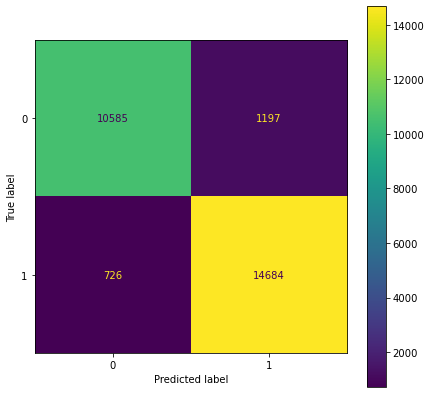

In [154]:
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(knn, X_val_scaled, y_val, ax=ax); 

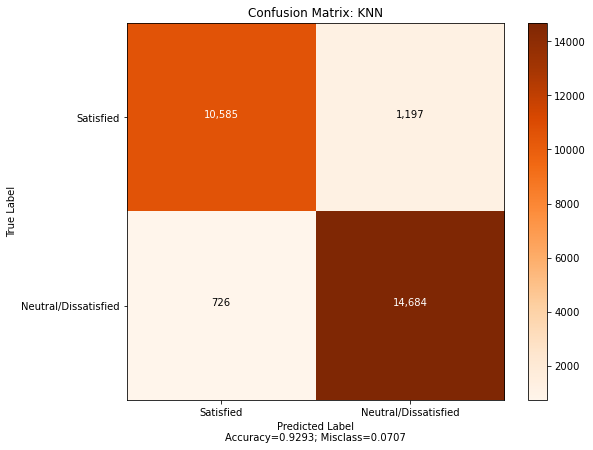

In [172]:
# Confustion Matrix with Optimal K
# Confusion Matrix --- looking at all of data to know which are TP, FP, 

knn_cm = confusion_matrix(y_val, knn_preds)
knn_cm
plot_kconfusion_matrix(knn_cm, normalize=False, target_names=['Satisfied', 'Neutral/Dissatisfied'], title='Confusion Matrix: {}'.format('KNN'))


### Cross Validating K

In [86]:
# Testing K for optimal k with cross validation

ks = range(1, 30)

cv_scores = np.zeros(len(list(ks)))

for i, k in enumerate(ks):
    knn = KNeighborsClassifier(n_neighbors = k)
    cv_score_mean = cross_val_score(knn, X_cval, y, cv=3).mean()
    cv_scores[i] = cv_score_mean

In [87]:
# Finding best K/score with cross validation
best_k = list(ks)[np.argmax(cv_scores)]

best_score = np.max(cv_scores)

print(f'Optimal number of Neighbors: {best_k}\nBest CV Score Mean: {best_score:.5f}')

Optimal number of Neighbors: 6
Best CV Score Mean: 0.92739


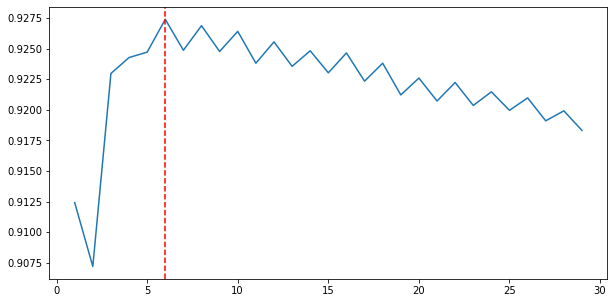

In [147]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(list(ks), cv_scores)
ax.axvline(list(ks)[np.argmax(cv_scores)], linestyle='--', color='red');

## Cross Validation on Models 
- Logistic Regression
- GaussianNB
- SVC
- Decision Tree Classifer
- Random Forest Classifier


In [ ]:
# Model_fit function

def model_fit(model, X_train_scaled, y_train):
    model.fit(X_train_scaled, y_train)
    return model.score(X_val_scaled, y_val)

### K Nearest Neighbors

In [220]:
knn = KNeighborsClassifier(n_neighbors = 6)

knn_cvs_score = cross_val_score(knn, X_train_scaled, y_train, cv=5)

print("Cross Validation Scores: ", knn_cvs_score)
print("Mean Score: ", knn_cvs_score.mean())

Cross Validation Scores:  [0.92434988 0.92332545 0.92308905 0.92568366 0.9269446 ]
Mean Score:  0.9246785284201844


In [221]:
model_fit(knn, X_train_scaled, y_train)
knn_pred = knn.predict(X_val_scaled)
print(classification_report(y_val, knn_pred))

print("=== All AUC Scores ===")
print(knn_cvs_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - K Nearest Neighbors: ", knn_cvs_score.mean())

              precision    recall  f1-score   support

           0       0.94      0.90      0.92     11782
           1       0.92      0.95      0.94     15410

    accuracy                           0.93     27192
   macro avg       0.93      0.93      0.93     27192
weighted avg       0.93      0.93      0.93     27192

=== All AUC Scores ===
[0.92434988 0.92332545 0.92308905 0.92568366 0.9269446 ]


=== Mean AUC Score ===
Mean AUC Score - K Nearest Neighbors:  0.9246785284201844


=== Confusion Matrix ===
[[10585  1197]
 [  726 14684]]




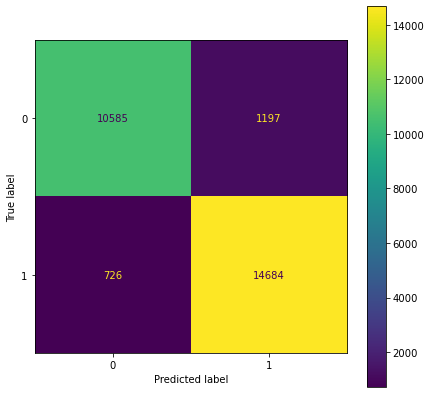

In [222]:
print("=== Confusion Matrix ===")
print(confusion_matrix(y_val, knn_pred))
print('\n')

fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(knn, X_val_scaled, y_val, ax=ax);

###  Logistic Regression

In [137]:
lr = LogisticRegression()
cvs = cross_val_score(lr, X_train_scaled, y_train, cv=5)

print("Cross Validaiton Scores: ", cvs)
print("Mean Score: ", cvs.mean())

CV Scores:  [0.8751773  0.87044917 0.87202522 0.86854756 0.8707542 ]
Mean Score:  0.8713906903350264


In [202]:
logistic = LogisticRegression(penalty='none')
model_fit(logistic, X_train_scaled, y_train)
log_val_pred = logistic.predict(X_val_scaled)

print(classification_report(y_val, log_val_pred))

              precision    recall  f1-score   support

           0       0.87      0.84      0.86     11782
           1       0.88      0.90      0.89     15410

    accuracy                           0.88     27192
   macro avg       0.88      0.87      0.87     27192
weighted avg       0.88      0.88      0.88     27192



In [ ]:
## Not working

logistic_cm = confusion_matrix(y_val, log_val_pred)
logistic_cm
plot_kconfusion_matrix(logistic, normalize=False, target_names=['Satisfied', 'Neutral/Dissatisfied'], title='Confusion Matrix: {}'.format('Logistic'))

=== Confusion Matrix ===
[[ 9906  1876]
 [ 1476 13934]]




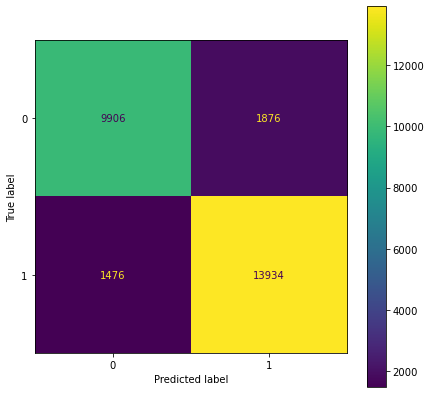

In [187]:
print("=== Confusion Matrix ===")
print(confusion_matrix(y_val, log_val_pred))
print('\n')

fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(logistic, X_val_scaled, y_val, ax=ax);

### Gaussian

In [225]:
gauss = GaussianNB()
gauss_cvs_score = cross_val_score(gauss, X_train_scaled, y_train, cv=5)

print("Cross Validation Scores: ", gauss_cvs_score)
print("Mean Score: ", gauss_cvs_score.mean())

Cross Validation Scores:  [0.85090623 0.84381403 0.84704492 0.8482938  0.84986997]
Mean Score:  0.8479857866629456


In [227]:
model_fit(gauss, X_train_scaled, y_train)
gauss_pred = gauss.predict(X_val_scaled)
print(classification_report(y_val, gauss_pred))

print("=== All AUC Scores ===")
print(gauss_cvs_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Gaussian Classifier: ", gauss_cvs_score.mean())

              precision    recall  f1-score   support

           0       0.83      0.82      0.83     11782
           1       0.87      0.88      0.87     15410

    accuracy                           0.85     27192
   macro avg       0.85      0.85      0.85     27192
weighted avg       0.85      0.85      0.85     27192

=== All AUC Scores ===
[0.85090623 0.84381403 0.84704492 0.8482938  0.84986997]


=== Mean AUC Score ===
Mean AUC Score - Gaussian Classifier:  0.8479857866629456


=== Confusion Matrix ===
[[ 9689  2093]
 [ 1922 13488]]




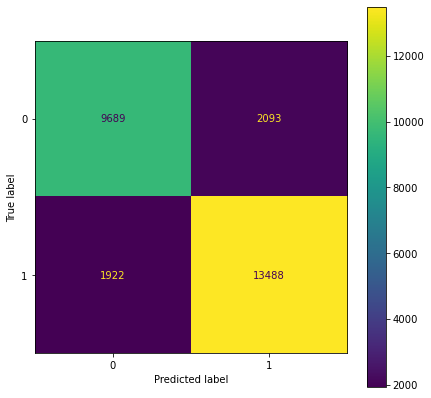

In [228]:
print("=== Confusion Matrix ===")
print(confusion_matrix(y_val, gauss_pred))
print('\n')

fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(gauss, X_val_scaled, y_val, ax=ax);

### SVC

In [229]:
svm = SVC()
svm_cvs_score = cross_val_score(svm, X_train_scaled, y_train, cv=5)

print("Cross Validation Scores: ", svm_cvs_score)
print("Mean Score: ", svm_cvs_score.mean())

Cross Validation Scores:  [0.95185185 0.94877857 0.94940898 0.94956261 0.94979904]
Mean Score:  0.9498802105855292


In [230]:
model_fit(svm, X_train_scaled, y_train)
svm_pred = svm.predict(X_val_scaled)
print(classification_report(y_val, svm_pred))

print("=== All AUC Scores ===")
print(svm_cvs_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - SVM Classifier: ", svm_cvs_score.mean())

              precision    recall  f1-score   support

           0       0.96      0.93      0.94     11782
           1       0.95      0.97      0.96     15410

    accuracy                           0.95     27192
   macro avg       0.95      0.95      0.95     27192
weighted avg       0.95      0.95      0.95     27192

=== All AUC Scores ===
[0.95185185 0.94877857 0.94940898 0.94956261 0.94979904]


=== Mean AUC Score ===
Mean AUC Score - SVC Classifier:  0.9498802105855292


=== Confusion Matrix ===
[[10990   792]
 [  510 14900]]




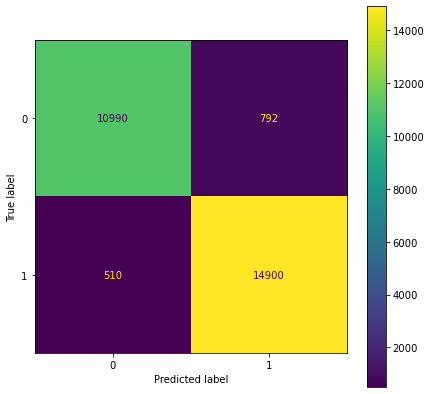

In [231]:
print("=== Confusion Matrix ===")
print(confusion_matrix(y_val,svm_pred))
print('\n')

fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(svm, X_val_scaled, y_val, ax=ax);

### Decision Tree Classifier

In [213]:
dtc = DecisionTreeClassifier()

dtc_cvs_score = cross_val_score(dtc, X_train_scaled, y_train, cv=5)

print("Cross Validation Scores: ", dtc_cvs_score)
print("Mean Score: ", dtc_cvs_score.mean())

Cross Validation Scores:  [0.9427896  0.93806147 0.94160757 0.93884467 0.94183939]
Mean Score:  0.9406285371797802


In [218]:
model_fit(dtc, X_train_scaled, y_train)
dtc_pred = dtc.predict(X_val_scaled)
print(classification_report(y_val, dtc_pred))

print("=== All AUC Scores ===")
print(dtc_cvs_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Decision Tree Classifier: ", dtc_cvs_score.mean())

              precision    recall  f1-score   support

           0       0.93      0.94      0.93     11782
           1       0.95      0.95      0.95     15410

    accuracy                           0.94     27192
   macro avg       0.94      0.94      0.94     27192
weighted avg       0.94      0.94      0.94     27192

=== All AUC Scores ===
[0.9427896  0.93806147 0.94160757 0.93884467 0.94183939]


=== Mean AUC Score ===
Mean AUC Score - Decision Tree Classifier:  0.9406285371797802


=== Confusion Matrix ===
[[11044   738]
 [  801 14609]]




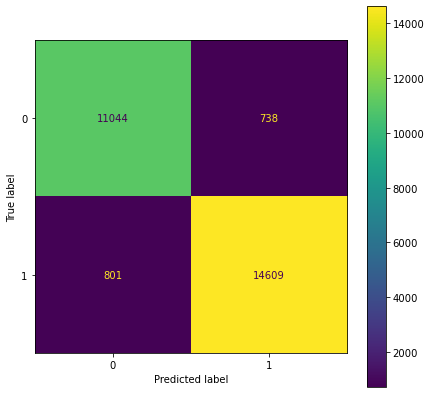

In [224]:
print("=== Confusion Matrix ===")
print(confusion_matrix(y_val, dtc_pred))
print('\n')

fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(dtc, X_val_scaled, y_val, ax=ax);

### Random Forest Classifier

In [167]:
rfc = RandomForestClassifier(n_estimators = 100) #100 = default

rfc_cv_score = cross_val_score(rfc, X_train_scaled, y_train, cv=5)

print("Cross Validation Scores: ", rfc_cv_score)
print("Mean Score: ", cvs.mean())

Cross Validation Scores:  [0.96028369 0.95973207 0.95831363 0.95673418 0.96083222]
Mean Score:  0.9593367573075244


In [205]:
model_fit(rfc, X_train_scaled, y_train)
rfc_pred = rfc.predict(X_val_scaled)
print(classification_report(y_val, rfc_pred))

print("=== All AUC Scores ===")
print(rfc_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())

              precision    recall  f1-score   support

           0       0.97      0.94      0.95     11782
           1       0.96      0.98      0.97     15410

    accuracy                           0.96     27192
   macro avg       0.96      0.96      0.96     27192
weighted avg       0.96      0.96      0.96     27192

=== All AUC Scores ===
[0.96028369 0.95973207 0.95831363 0.95673418 0.96083222]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.9591791578628227


In [177]:
print("=== Confusion Matrix ===")
print(confusion_matrix(y_val, rfc_pred))
print('\n')


=== Confusion Matrix ===
[[11078   704]
 [  377 15033]]




In [ ]:

# NOT WORKING
rfc_cm = confusion_matrix(y_val, rfc_pred)
rfc_cm
plot_kconfusion_matrix(rfc, normalize=False, target_names=['Satisfied', 'Neutral/Dissatisfied'], title='Confusion Matrix: {}'.format('RFC'))

In [232]:
### XG Boost

NameError: name 'LinearRegression' is not defined